[*********************100%***********************]  1 of 1 completed



Training Linear Regression model...

Training LSTM model...
Epoch 1/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 9s 121ms/step - loss: 0.0061 - val_loss: 0.0024 - learning_rate: 0.0010
Epoch 2/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 130ms/step - loss: 3.6243e-04 - val_loss: 6.6603e-04 - learning_rate: 0.0010
Epoch 3/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 128ms/step - loss: 2.8513e-04 - val_loss: 7.9413e-04 - learning_rate: 0.0010
Epoch 4/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 130ms/step - loss: 2.8623e-04 - val_loss: 4.3508e-04 - learning_rate: 0.0010
Epoch 5/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 132ms/step - loss: 2.0791e-04 - val_loss: 4.0849e-04 - learning_rate: 0.0010
Epoch 6/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 2.5787e-04 - val_loss: 4.5572e-04 - learning_rate: 0.0010
Epoch 7/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 135ms/step - loss: 2.6228e-04 - val_loss: 4.1235e-04 - learning_rate: 0.0010
Epoch 8/100
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 133ms/step - loss: 2.3111e-04 - val_loss: 4.7839e-04 - learning_rate: 0.

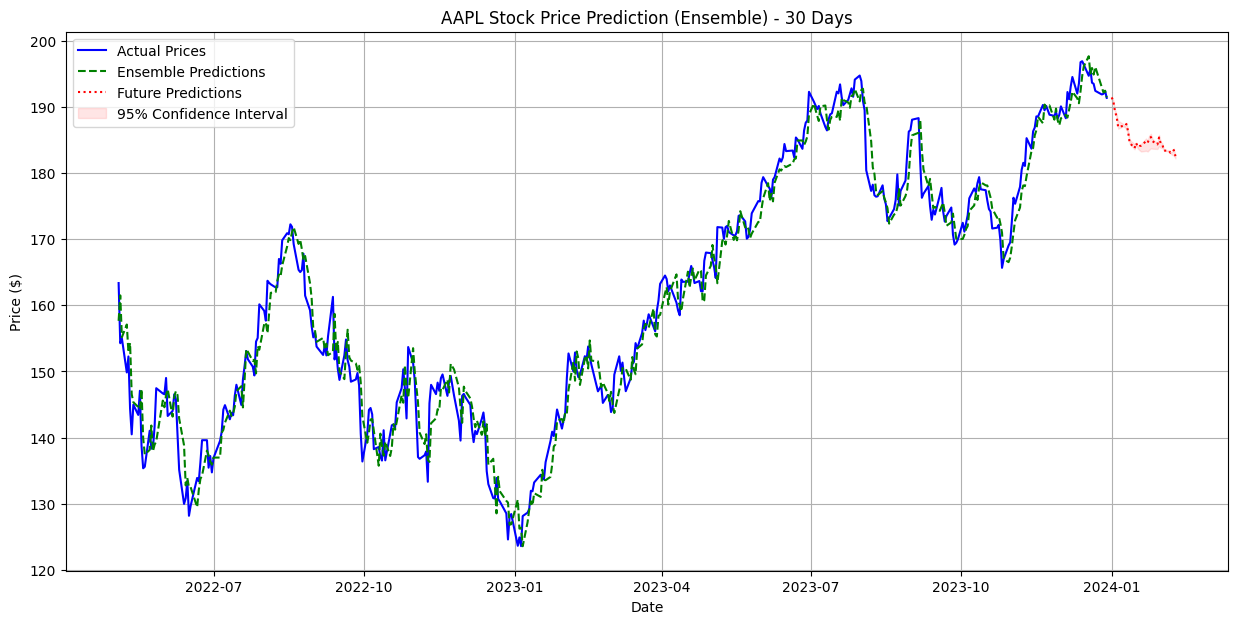


Model Metrics:

Linear Regression Metrics:
MSE: 10.4030
MAE: 2.4571
RMSE: 3.2254
MAPE: 1.5785

LSTM Metrics:
MSE: 18.8690
MAE: 3.5112
RMSE: 4.3439
MAPE: 2.2308

Ensemble Metrics:
MSE: 10.0244
MAE: 2.4868
RMSE: 3.1661
MAPE: 1.5912

Future Predictions with Confidence Intervals:
2024-01-01: $191.45 (95% CI: $190.99 - $191.57)
2024-01-02: $190.94 (95% CI: $190.49 - $191.07)
2024-01-03: $189.39 (95% CI: $189.33 - $189.61)
2024-01-04: $188.57 (95% CI: $188.48 - $188.94)
2024-01-05: $186.97 (95% CI: $186.71 - $187.91)
2024-01-08: $187.15 (95% CI: $187.06 - $187.47)
2024-01-09: $187.10 (95% CI: $186.96 - $187.14)
2024-01-10: $187.42 (95% CI: $186.66 - $187.64)
2024-01-11: $186.40 (95% CI: $185.97 - $186.51)
2024-01-12: $184.60 (95% CI: $184.48 - $185.04)
2024-01-15: $183.77 (95% CI: $183.60 - $184.39)
2024-01-16: $184.54 (95% CI: $184.26 - $184.63)
2024-01-17: $183.97 (95% CI: $183.71 - $184.05)
2024-01-18: $184.10 (95% CI: $183.47 - $184.28)
2024-01-19: $184.15 (95% CI: $183.27 - $184.40)
20

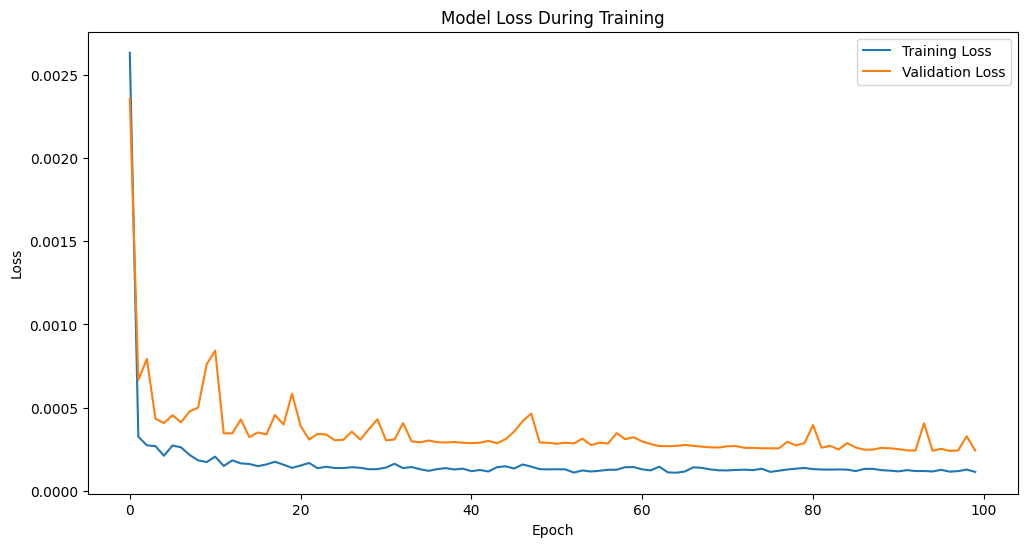

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_squared_error, mean_absolute_error


def prepare_data(stock, lookback):
    """Prepare data with enhanced features while maintaining focus on closing price"""
    price_scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_price = price_scaler.fit_transform(stock[['Close']].values)
    
    X, y = [], []
    for i in range(lookback, len(scaled_price)):
        X.append(scaled_price[i-lookback:i, 0])
        y.append(scaled_price[i, 0])
    
    X, y = np.array(X), np.array(y)
    
    train_size = int(len(X) * 0.8)
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    return X_train, X_test, y_train, y_test, price_scaler

def calculate_confidence_intervals(predictions_lr, predictions_lstm):
    """Calculate confidence intervals with proper dimensions"""
    pred_lr = predictions_lr.flatten()
    pred_lstm = predictions_lstm.flatten()
    
    mean_pred = (pred_lr + pred_lstm) / 2
    std_dev = np.std([pred_lr, pred_lstm], axis=0)
    
    interval_width = 0.5
    time_factor = np.linspace(1, 1.1, len(mean_pred))
    
    upper_bound = mean_pred + (interval_width * std_dev * time_factor)
    lower_bound = mean_pred - (interval_width * std_dev * time_factor)
    
    return lower_bound, upper_bound

def train_and_evaluate(ticker="AAPL", start_date="2015-01-01", end_date="2024-01-01", 
                      lookback=60, future_days=90):
    """Train models and make predictions"""
    # Download data
    print(f"Downloading data for {ticker}...")
    stock = yf.download(ticker, start=start_date, end=end_date)
    
    # Prepare data
    data = stock[['Close']].values
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)
    
    # Create sequences
    X, y = [], []
    for i in range(lookback, len(scaled_data)):
        X.append(scaled_data[i-lookback:i, 0])
        y.append(scaled_data[i, 0])
    
    X, y = np.array(X), np.array(y)
    
    # Split data
    train_size = int(len(X) * 0.8)
    X_train = X[:train_size]
    X_test = X[train_size:]
    y_train = y[:train_size]
    y_test = y[train_size:]
    
    # Prepare data for LSTM
    X_train_lstm = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test_lstm = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Train Linear Regression model
    print("\nTraining Linear Regression model...")
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    
    # Train LSTM model
    print("\nTraining LSTM model...")
    lstm_model = Sequential([
        Input(shape=(lookback, 1)),
        LSTM(100, return_sequences=True),
        Dropout(0.2),
        LSTM(50, return_sequences=False),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])
    
    optimizer = Adam(learning_rate=0.001)
    lstm_model.compile(optimizer=optimizer, loss='huber')
    
    callbacks = [
        EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=0.0001)
    ]
    
    history = lstm_model.fit(
        X_train_lstm, y_train,
        epochs=100,
        batch_size=32,
        validation_split=0.2,
        callbacks=callbacks,
        verbose=1
    )
    
    # Make predictions
    lr_pred = lr_model.predict(X_test)
    lstm_pred = lstm_model.predict(X_test_lstm)
    
    # Inverse transform predictions
    lr_pred = scaler.inverse_transform(lr_pred.reshape(-1, 1))
    lstm_pred = scaler.inverse_transform(lstm_pred.reshape(-1, 1))
    actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
    
    # Calculate model weights
    lr_mse = mean_squared_error(actual_prices, lr_pred)
    lstm_mse = mean_squared_error(actual_prices, lstm_pred)
    
    total_error = lr_mse + lstm_mse
    lr_weight = 1 - (lr_mse / total_error)
    lstm_weight = 1 - (lstm_mse / total_error)
    
    total_weight = lr_weight + lstm_weight
    lr_weight = lr_weight / total_weight
    lstm_weight = lstm_weight / total_weight
    
    print(f"\nModel weights based on performance:")
    print(f"Linear Regression weight: {lr_weight:.4f}")
    print(f"LSTM weight: {lstm_weight:.4f}")
    
    # Create ensemble predictions
    ensemble_pred = lr_weight * lr_pred + lstm_weight * lstm_pred
    
    # Calculate metrics
    metrics = {
        'Linear Regression': {
            'MSE': mean_squared_error(actual_prices, lr_pred),
            'MAE': mean_absolute_error(actual_prices, lr_pred),
            'RMSE': np.sqrt(mean_squared_error(actual_prices, lr_pred)),
            'MAPE': np.mean(np.abs((actual_prices - lr_pred) / actual_prices)) * 100
        },
        'LSTM': {
            'MSE': mean_squared_error(actual_prices, lstm_pred),
            'MAE': mean_absolute_error(actual_prices, lstm_pred),
            'RMSE': np.sqrt(mean_squared_error(actual_prices, lstm_pred)),
            'MAPE': np.mean(np.abs((actual_prices - lstm_pred) / actual_prices)) * 100
        },
        'Ensemble': {
            'MSE': mean_squared_error(actual_prices, ensemble_pred),
            'MAE': mean_absolute_error(actual_prices, ensemble_pred),
            'RMSE': np.sqrt(mean_squared_error(actual_prices, ensemble_pred)),
            'MAPE': np.mean(np.abs((actual_prices - ensemble_pred) / actual_prices)) * 100
        }
    }
    
    # Predict future prices - Fixed version
    last_sequence = X_test[-1].reshape(1, lookback)
    last_sequence_lstm = last_sequence.reshape(1, lookback, 1)
    
    future_pred_lr = []
    future_pred_lstm = []
    current_sequence = last_sequence.copy()
    current_sequence_lstm = last_sequence_lstm.copy()
    
    for _ in range(future_days):
        # Linear Regression prediction
        next_pred_lr = lr_model.predict(current_sequence).item()  # Extract scalar value
        future_pred_lr.append(next_pred_lr)
        
        # LSTM prediction
        next_pred_lstm = lstm_model.predict(current_sequence_lstm, verbose=0).item()  # Extract scalar value
        future_pred_lstm.append(next_pred_lstm)
        
        # Calculate weighted prediction
        weighted_pred = lr_weight * next_pred_lr + lstm_weight * next_pred_lstm
        
        # Update sequences - Fixed version
        current_sequence = np.roll(current_sequence, -1, axis=1)
        current_sequence[0, -1] = weighted_pred
        
        current_sequence_lstm = np.roll(current_sequence_lstm, -1, axis=1)
        current_sequence_lstm[0, -1, 0] = weighted_pred
    
    # Transform predictions back to original scale
    future_pred_lr = scaler.inverse_transform(np.array(future_pred_lr).reshape(-1, 1))
    future_pred_lstm = scaler.inverse_transform(np.array(future_pred_lstm).reshape(-1, 1))
    future_pred_ensemble = lr_weight * future_pred_lr + lstm_weight * future_pred_lstm
    
    # Calculate confidence intervals
    lower_bound, upper_bound = calculate_confidence_intervals(future_pred_lr, future_pred_lstm)
    
    # Create future dates
    last_date = stock.index[-1]
    future_dates = pd.date_range(start=last_date, periods=future_days+1, freq='B')[1:]
    
    # Plot results
    plt.figure(figsize=(15, 7))
    plt.plot(stock.index[-len(actual_prices):], actual_prices, label='Actual Prices', color='blue')
    plt.plot(stock.index[-len(ensemble_pred):], ensemble_pred, label='Ensemble Predictions', color='green', linestyle='--')
    plt.plot(future_dates, future_pred_ensemble, label='Future Predictions', color='red', linestyle=':')
    
    plt.fill_between(future_dates, lower_bound, upper_bound,
                    color='red', alpha=0.1, label='95% Confidence Interval')
    
    plt.title(f'{ticker} Stock Price Prediction (Ensemble) - {future_days} Days')
    plt.xlabel('Date')
    plt.ylabel('Price ($)')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    # Print metrics
    print("\nModel Metrics:")
    for model_name, model_metrics in metrics.items():
        print(f"\n{model_name} Metrics:")
        for metric_name, value in model_metrics.items():
            print(f"{metric_name}: {value:.4f}")
    
    print(f"\nFuture Predictions with Confidence Intervals:")
    for date, pred, lower, upper in zip(future_dates, future_pred_ensemble, lower_bound, upper_bound):
        pred_value = float(pred[0]) if isinstance(pred, np.ndarray) else float(pred)
        lower_value = float(lower) if isinstance(lower, np.ndarray) else float(lower)
        upper_value = float(upper) if isinstance(upper, np.ndarray) else float(upper)
        print(f"{date.date()}: ${pred_value:.2f} (95% CI: ${lower_value:.2f} - ${upper_value:.2f})")
    
    return lstm_model, lr_model, scaler, history, metrics
if __name__ == "__main__":
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    # Train model and make predictions
    lstm_model, lr_model, scaler, history, metrics = train_and_evaluate(
        ticker="AAPL",
        start_date="2015-01-01",
        end_date="2024-01-01",
        lookback=180,
        future_days=30
    )
    
    # Plot training history
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss During Training')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()